In [2]:
import cv2 as cv
from scipy.signal import find_peaks
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np

In [13]:

cam = cv.VideoCapture('http://192.168.123.12:8080/?action=stream')
h, w = 480, 848 #img.shape
h_half, w_half = int(h/2), int(w/2)
canvas = np.zeros((h,w,1),dtype = "uint8")

plt.close('all')

while 1:
    ret, img = cam.read()

    clear_output(wait=True)
    l_pos, r_pos = [],[]
    ddmean = 0
    for j in range(3): #rgb
        meanVec = []
        for i in range(10):
            meanVec.append(img[h_half+i,:, j])
        meanVec = np.mean(meanVec, axis=0)
        ddmean = np.diff(meanVec) #dy/dx
        #ddmean = np.convolve(meanVec,[-1,0,1])
        ddmean = np.abs(np.convolve(ddmean,(1/9)*np.ones(9))) #mean+abs filter
        peaks, _ = find_peaks(ddmean[0:int(w_half)], prominence=1,width=5) #left image
        peaks2, _ = find_peaks(ddmean[w_half:-1], prominence=1,width=5) #Right image 
        if len(peaks)>0:
            l_pos.append(peaks[-1])
        if len(peaks2)>0:
            r_pos.append(peaks2[0])
        
    if len(l_pos)>0:
        cen = np.mean(l_pos, dtype=int)
        cv.line(img, (cen,0),(cen,w), (0,0,255), 3)
        
    
    if len(r_pos)>0:
        cen = w_half+np.mean(r_pos, dtype=int)#peaks2[0]#w_half+int((peaks2[0]+peaks2[1])/2)
        cv.line(img, (cen,0),(cen,w), (0,255,0), 3)
        
    cv.line(img, (w_half,0),(w_half,w), (255,0,0), 3) #middle line
    cv.imshow('D435 image', img)
    if len(peaks)>0 and len(peaks2)>0:
        pos = w_half-(peaks[-1]+w_half+peaks2[0])/2
        print(pos)
    #cv.imshow('D435 image', img[:,:,0])
    # plt.plot(ddmean)
    # plt.plot([w_half,w_half], [0,20])
    # plt.plot(peaks, ddmean[peaks], 'rx')
    # plt.plot(w_half+peaks2, ddmean[w_half:-1][peaks2], 'rx')
    # plt.show()
    
    if 0xFF & cv.waitKey(5) == 27:
        break
cv.destroyAllWindows()

48.0


In [25]:
ddmean[w_half:-1].size

433

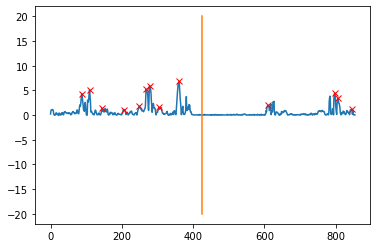

In [45]:
# ddmean = np.convolve(meanVec,[-1,0,1])
# ddmean = np.convolve(ddmean,0.1*np.ones(9))
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
plt.close('all')
fig = plt.figure() #constrained_layout=True
gs = fig.add_gridspec(1, 1)
ax=[]
ax.append(fig.add_subplot(gs[0]))
thisAx = ax[0]

thisAx.plot(ddmean)
thisAx.plot([w_half,w_half], [-20,20])
thisAx.plot(peaks, ddmean[peaks], 'rx')
thisAx.plot(w_half+peaks2, ddmean[w_half:-1][peaks2], 'rx')
#thisAx.plot(peaks2, ddmean[peaks2], 'rx')

## ORB

In [12]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import copy

class imgOrb:
    def __init__(self, image):
        self.img = image
        self.orb = cv.ORB_create()
        self.kp = self.orb.detect(self.img,None)
        self.kp, self.des = self.orb.compute(self.img, self.kp)
    def drawKp(self):
        return cv.drawKeypoints(self.img, self.kp, None, color=(0,255,0), flags=0)
    #def __del__(self):
        # body of destructor

# My symbol
img = cv.imread('hkust.png')
myLogo = imgOrb(img)

#RGB camera
#cam = cv.VideoCapture(0)
cam = cv.VideoCapture('http://192.168.123.12:8080/?action=stream')
if cam.read() == False:
    cam.open()
if not cam.isOpened():
    print('Cannot open camera')
    exit()

ret,frame = cam.read()
lastframe = imgOrb(frame)


In [19]:
while True:
    ret,frame = cam.read()
    myCam = imgOrb(frame)
    matcher = cv.BFMatcher()
    matches = matcher.match(myCam.des,myLogo.des)
    final_img = cv.drawMatches(myCam.img, myCam.kp,myLogo.img, myLogo.kp, matches[:10],None)
    #print(len(matches))
    cv.imshow('ORB', final_img)
    lastframe = copy.copy(myCam)
    del myCam
    clear_output(wait=True)
    matchCnt = len(matches)-490
    print(matchCnt)
    if matchCnt > 10:
        print('matched')
    else:
        print('Unmatched')
    if cv.waitKey(1)&0xFF == ord('q'):
        break

10
Unmatched


## SIFT

In [24]:
import cv2
import numpy as np
import time
from IPython.display import clear_output

numberMatchingThreshold = 10 
posXMean = np.array([0,0,0])
#cam = cv2.VideoCapture(0) 
cam = cv2.VideoCapture('http://192.168.123.12:8080/?action=stream')

if cam.read() == False:
    cam.open()

if not cam.isOpened():
    print('Cannot open camera')


#SIFT
sift = cv2.xfeatures2d.SIFT_create()

img = cv2.imread('hkust.png', cv2.IMREAD_COLOR)

scale_percent = 100
dim = (int(img.shape[1] * scale_percent / 100), int(img.shape[0] * scale_percent / 100))
img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)


kp1, des1 = sift.detectAndCompute(img,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)


while True:
    ret,frame = cam.read()
    
    h, w, c = frame.shape
    kp2, des2, matches = 0,0,0
    try:
        kp2, des2 = sift.detectAndCompute(frame,None)
        matches = flann.knnMatch(des1,des2,k=2)
    except:
        continue
    matchesMask = [[0,0] for i in range(len(matches))]
    good=[]
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            good.append(m)
            matchesMask[i]=[1,0]
    # Initialize lists
    x,y=[],[]
    for m in good:
        img2_idx = m.trainIdx
        (x2, y2) = kp2[img2_idx].pt
        x.append(x2)
        y.append(y2)
    x = np.array(x)
    y = np.array(y)
    clear_output(wait=True)
    if(len(good)>numberMatchingThreshold):
        posXMean=np.delete(posXMean, 0)
        posXMean=np.append(posXMean, np.mean(x)-w/2)
        print("matched:",len(good), np.mean(posXMean))

    else:
        posXMean = np.array([0,0,0])
        print("unmatched")
    
    #Plot
    draw_params = dict(matchColor = (0,255,0),singlePointColor = (255,0,0),matchesMask = matchesMask,flags = cv2.DrawMatchesFlags_DEFAULT)
    view=cv2.drawMatchesKnn(img,kp1,frame,kp2,matches,None,**draw_params)
    cv2.imshow('webcam', view)


    if cv2.waitKey(1)&0xFF == ord('q'):
        break

#cam.release()
cv2.destroyAllWindows()

matched: 32 -48.645728978656585
